# Caltech Pre-processing
**Purpose: Convert raw Caltech data to YOLO and COCO label formats**</br>
**Final Project**</br>
**Group 1**</br>
**DS6050 Deep Learning**</br>
**Fall 2023**</br>

In [2]:
import os
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from concurrent.futures import ThreadPoolExecutor
import matplotlib.patches as patches
from tqdm import tqdm
import shutil
from PIL import Image
from PIL import ImageDraw
import cv2
import numpy as np
from pycocotools.coco import COCO

In [ ]:
%pip install opencv-python pylabel -q

## Download Data

In [ ]:
!wget "https://data.caltech.edu/records/f6rph-90m20/files/data_and_labels.zip?download=1" -O caltechpedestriandataset.zip

## Unpack Data

In [ ]:
!unzip caltechpedestriandataset.zip -d caltechpedestriandataset

## Create YOLO Labels

In [ ]:
!caltech-to-yolo.py

## Validate YOLO Labels

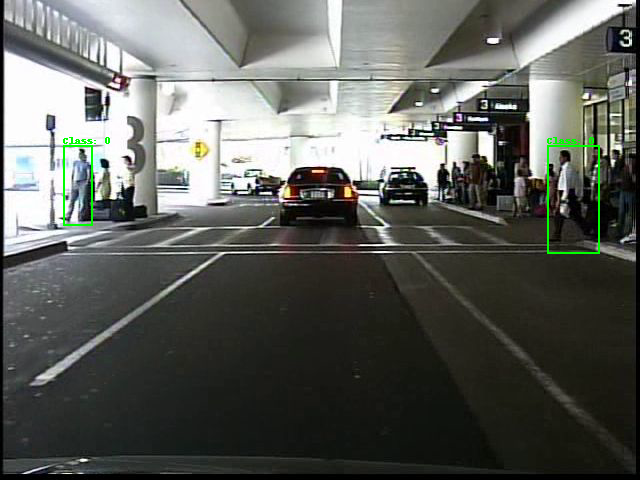

In [132]:
# Path to the YOLOv5 labels file
labels_path = '/scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/labels/train/set00_V008_0515.txt'

# Path to the image corresponding to the labels
image_path = '/scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/images/train/set00_V008_0515.png'

# Load the image
image = Image.open(image_path)

# Read the YOLOv5 labels file
with open(labels_path, 'r') as file:
    labels = file.read().strip().split('\n')

draw = ImageDraw.Draw(image)

for label in labels:
    parts = label.split()
    class_id = int(parts[0])
    x_center, y_center, width, height = map(float, parts[1:])
    
    # Convert YOLO format to image coordinates
    x, y, w, h = int((x_center - width / 2) * image.width), int((y_center - height / 2) * image.height), int(width * image.width), int(height * image.height)
    
    # Define a color for the bounding box (RGB format)
    color = (0, 255, 0)  # Green
    
    # Draw the bounding box on the image
    draw.rectangle([x, y, x + w, y + h], outline=color, width=2)
    
    # Display the class label on the image
    label_text = f'Class: {class_id}'
    draw.text((x, y - 10), label_text, fill=color)

# Display the image with bounding boxes
image

## Move Data (optional)

In [ ]:
!mv datasets/caltechpedestriandataset /scratch/ybt7qf/ds6050-group1-project/datasets --recursive

## Create YOLO Yaml

In [ ]:
%%writefile /scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset.yaml
path: /scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/
train: /scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/images/train
val: /scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/images/val
    
nc: 1
    
names: [
    'person'
]

## Convert Training and Validation Labels to COCO Format

In [1]:
# Define the paths to YOLO labels, the images directory, and the output COCO JSON file
mypaths = [
    ['/scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/labels/train/',
     '/scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/images/train/',
     '/scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/train2017',
     'custom_train.json'],
    ['/scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/labels/val/',
     '/scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/images/val/',
     '/scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/val2017',
     'custom_val.json']
]

for mp in mypaths:

    yolo_labels_directory = mp[0]   # Directory containing YOLO labels
    images_directory = mp[1]    # Directory containing the images
    coco_image_directory = mp[2]
    coco_json_path = mp[3]     # Output COCO JSON file

    # Define the class mapping between YOLO classes and COCO categories
    class_mapping = {'person': 0} #{value: key for key, value in identity_mapping.items()}

    # Initialize COCO data structures with empty "license" and "info" keys
    coco_data = {
        "images": [],
        "annotations": [],
        "categories": [],
        "licenses": [],  # Add an empty list for licenses
        "info": {}  # Add an empty dictionary for info
    }

    # Initialize image_id
    image_id = 0

    # Loop through YOLO labels and images to convert to COCO format
    for yolo_label_file in os.listdir(yolo_labels_directory):
        if yolo_label_file.endswith('.txt'):
            image_filename = os.path.splitext(yolo_label_file)[0] + '.png'  # Assuming image extensions are .jpg

            # Load the image to get its width and height
            image_path = os.path.join(images_directory, image_filename)
            image = Image.open(image_path)
            image_width, image_height = image.size

            # Increment image_id
            image_id += 1

            # Read YOLO labels and convert to COCO format
            with open(os.path.join(yolo_labels_directory, yolo_label_file), 'r') as yolo_file:
                for line in yolo_file:
                    data = line.strip().split()

                    # Extract information from YOLO label
                    class_index = int(data[0])
                    x_normalized, y_normalized, width_normalized, height_normalized = map(float, data[1:5])

                    # Map YOLO class to COCO category
                    category_id = class_index #class_mapping.get(class_index)

                    # Convert normalized coordinates to pixel values
                    x_center = int(x_normalized * image_width)
                    y_center = int(y_normalized * image_height)
                    width_pixel = int(width_normalized * image_width)
                    height_pixel = int(height_normalized * image_height)

                    # Calculate top-left corner coordinates
                    x_pixel = x_center - (width_pixel // 2)
                    y_pixel = y_center - (height_pixel // 2)

                    # Create COCO annotation
                    annotation = {
                        "id": len(coco_data["annotations"]) + 1,
                        "image_id": image_id,
                        "category_id": category_id,
                        "bbox": [x_pixel, y_pixel, width_pixel, height_pixel],
                        "area": width_pixel * height_pixel,
                        "iscrowd": 0,
                        "segmentation": []
                    }

                    coco_data["annotations"].append(annotation)

            # Create COCO categories (if not already created)
            for class_name, category_id in class_mapping.items():
                category = {
                    "id": category_id,
                    "name": class_name,
                    "supercategory": class_name
                }
                if category not in coco_data["categories"]:
                    coco_data["categories"].append(category)

            # Create COCO image data with the "folder" key
            image_data = {
                "id": image_id,
                "file_name": image_filename,
                "width": image_width,
                "height": image_height,
                "folder": coco_image_directory
            }
            coco_data["images"].append(image_data)

    # Save the COCO data as a JSON file
    with open(coco_json_path, 'w') as coco_file:
        json.dump(coco_data, coco_file, indent=4)

    print(f"COCO JSON data has been saved to {coco_json_path}")

COCO JSON data has been saved to custom_train.json
COCO JSON data has been saved to custom_val.json


In [ ]:
!mkdir /scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/annotations/

In [9]:
!mv custom_train.json /scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/annotations/custom_train.json

In [10]:
!mv custom_val.json /scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/annotations/custom_val.json

In [15]:
!ls /scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/annotations

custom_train.json  custom_val.json


## Move Images for COCO Structure

In [1]:
!mkdir /scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/train2017

In [5]:
!cp /scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/images/train/* \
    /scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/train2017/ --recursive

In [2]:
!mkdir /scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/val2017

In [6]:
!cp /scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/images/val/* \
    /scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/val2017/ --recursive

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
/scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/train2017/set00_V014_0368.png


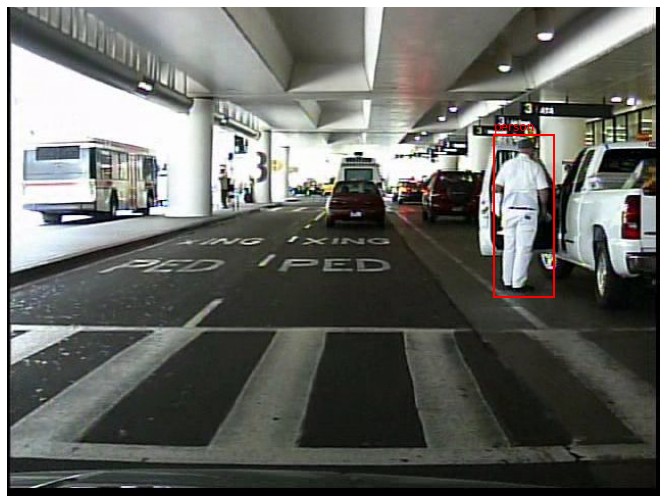

In [16]:
# Load the COCO dataset annotations file and the corresponding image
coco = COCO('/scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/annotations/custom_train.json')  # Replace 'annotations_file.json' with your JSON annotations file
image_id = 150  # Replace with the desired image ID
image_info = coco.loadImgs(image_id)[0]
image_path = image_info['folder']+"/"+image_info['file_name']  # Replace with the path to your image
print(image_path)

# Load the image
image = plt.imread(image_path)

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, figsize=(12, 9))

# Display the image
ax.imshow(image)

# Load annotations for the selected image
ann_ids = coco.getAnnIds(imgIds=image_id)
annotations = coco.loadAnns(ann_ids)

# Loop through annotations and plot bounding boxes
for annotation in annotations:
    bbox = annotation['bbox']
    category_id = annotation['category_id']
    category = coco.loadCats(category_id)[0]['name']

    # Extract the (x, y) coordinates and dimensions of the bounding box
    x, y, width, height = bbox
    x, y, width, height = int(x), int(y), int(width), int(height)

    # Create a Rectangle patch
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')

    # Add the Rectangle patch to the axis
    ax.add_patch(rect)

    # Display the category label near the bounding box
    plt.text(x, y - 5, f'{category}', color='red', fontsize=12)

# Hide axis labels and ticks
ax.axis('off')

# Show the image with annotations
plt.show()